In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00


In [5]:
import torch
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [11]:
from scipy import io
mat_file = io.loadmat("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/130@6_0.mat")
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Jan 31 13:59:43 2000',
 '__version__': '1.0',
 '__globals__': [],
 'X130_DE_time': array([[ 0.00852784],
        [ 0.4235496 ],
        [ 0.01299481],
        ...,
        [ 0.17583603],
        [ 0.1100498 ],
        [-0.10274022]]),
 'X130_FE_time': array([[-0.40700545],
        [ 0.26277636],
        [ 0.49514545],
        ...,
        [ 0.05958182],
        [-0.05074727],
        [ 0.02732545]]),
 'X130_BA_time': array([[-4.02373887e-05],
        [ 6.93290208e-02],
        [ 3.06608902e-02],
        ...,
        [ 1.18297923e-01],
        [ 5.66542433e-02],
        [-1.05019585e-02]]),
 'X130RPM': array([[1796]], dtype=uint16)}

        motor1_x  motor1_y
402286 -0.056952 -0.040885
211646  0.043183  0.016231
218166 -0.030875  0.157378
478771 -0.052571  0.019107
70442  -0.028789  0.099645
...          ...       ...
301660  0.043809 -0.074580
308401  0.062167  0.019313
56336  -0.083446 -0.084647
309338 -0.105768  0.121424
379524 -0.104934  0.135189

[8000 rows x 2 columns]
        motor1_x  motor1_y
67877  -0.040284  0.126149
20571  -0.130111 -0.026093
66886  -0.004873 -0.004109
68240   0.231632 -0.077251
3046    0.095349 -0.000616
...          ...       ...
61828  -0.063350  0.000000
103345 -0.059126  0.123889
19814   0.016893 -0.069649
26198   0.120364 -0.031024
93524   0.032974 -0.074169

[8000 rows x 2 columns]
        motor1_x  motor1_y
60270  -0.128324  0.027736
50394   0.140182 -0.011505
117999 -0.048731  0.077662
80356  -0.024853  0.054445
66652  -0.001137  0.126560
...          ...       ...
57675  -0.159349  0.225795
42161   0.121664  0.108069
105751  0.049380  0.174842
91469   0.013401  0.187375
18308

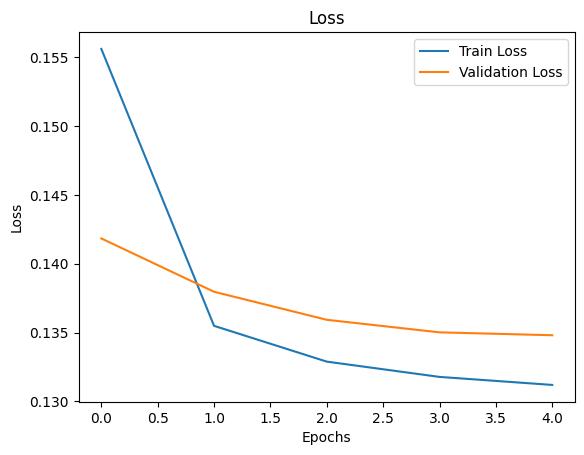

7/7 [==============================] - 0s 4ms/step


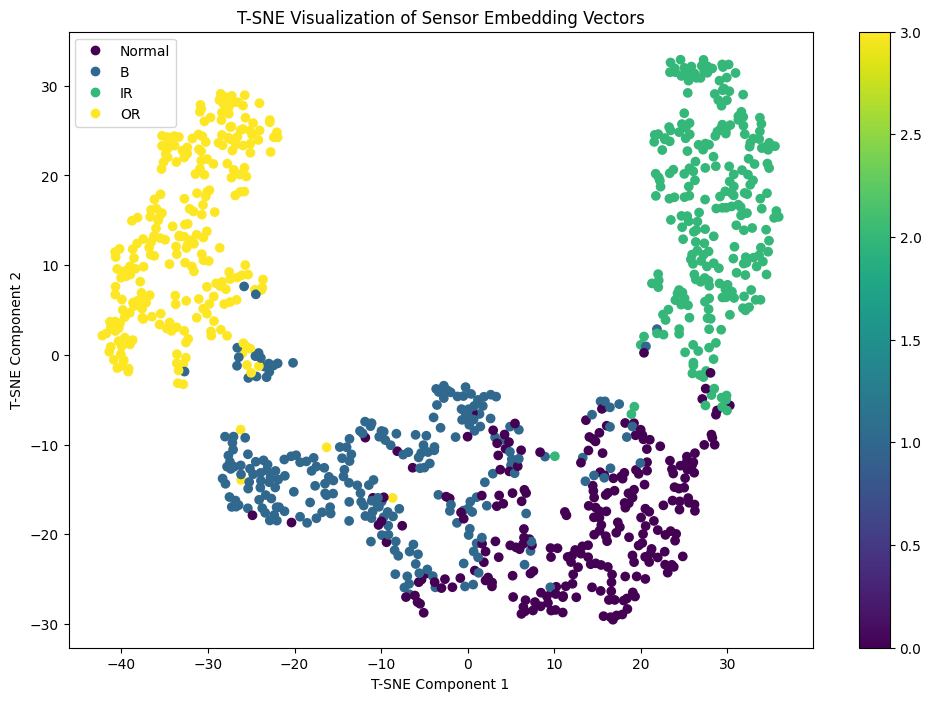

Training classifier model...
Epoch 1/1000
199/199 [==============================] - 2s 5ms/step - loss: 1.0742 - accuracy: 0.5327 - val_loss: 0.6769 - val_accuracy: 0.7750
Epoch 2/1000
199/199 [==============================] - 1s 4ms/step - loss: 0.6556 - accuracy: 0.7312 - val_loss: 0.4534 - val_accuracy: 0.8550
Epoch 3/1000
199/199 [==============================] - 1s 4ms/step - loss: 0.4994 - accuracy: 0.7977 - val_loss: 0.3773 - val_accuracy: 0.8750
Epoch 4/1000
199/199 [==============================] - 1s 4ms/step - loss: 0.4289 - accuracy: 0.8354 - val_loss: 0.3332 - val_accuracy: 0.8650
Epoch 5/1000
199/199 [==============================] - 1s 4ms/step - loss: 0.4117 - accuracy: 0.8367 - val_loss: 0.3064 - val_accuracy: 0.8800
Epoch 6/1000
199/199 [==============================] - 1s 4ms/step - loss: 0.4120 - accuracy: 0.8254 - val_loss: 0.3041 - val_accuracy: 0.8700
Epoch 7/1000
199/199 [==============================] - 1s 4ms/step - loss: 0.3667 - accuracy: 0.8681 - val

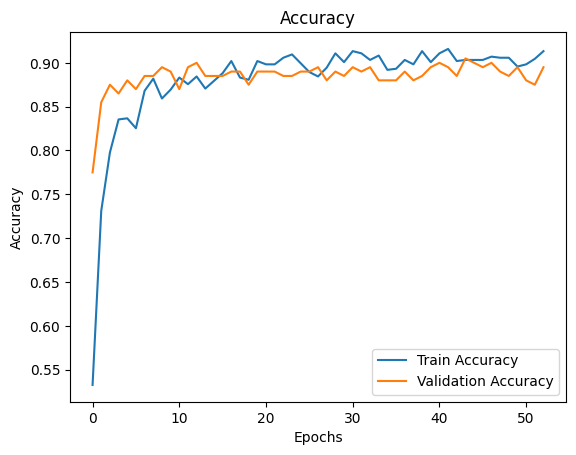

7/7 [==============================] - 0s 2ms/step


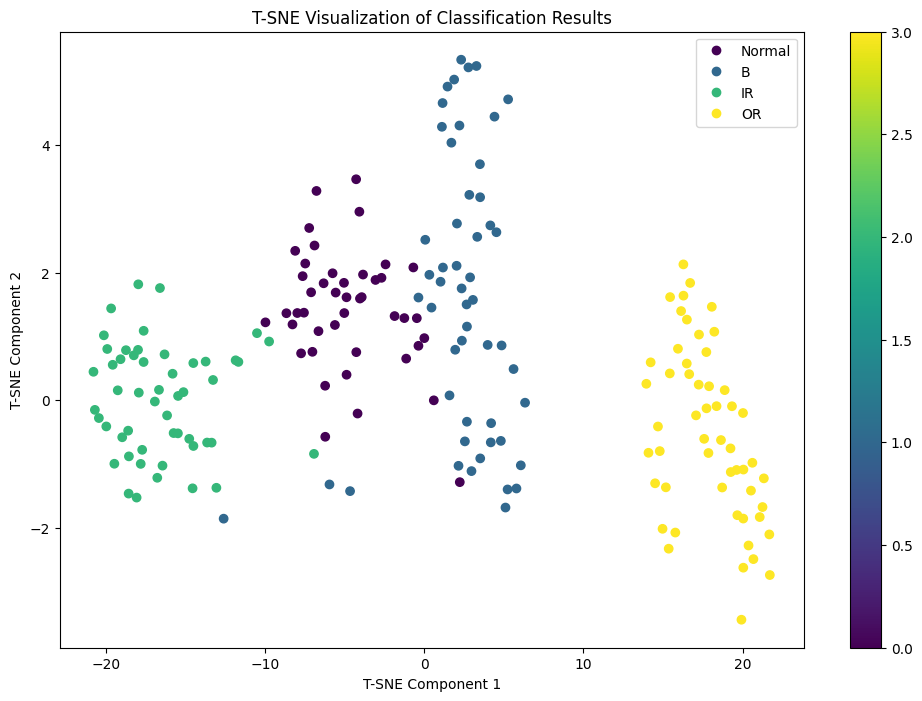

Accuracy on test set: 0.895
F1 Score on test set: 0.8937199046951854
              precision    recall  f1-score   support

      Normal       0.89      0.78      0.83        50
           B       0.79      0.82      0.80        50
          IR       0.96      0.98      0.97        50
          OR       0.94      1.00      0.97        50

    accuracy                           0.90       200
   macro avg       0.89      0.90      0.89       200
weighted avg       0.89      0.90      0.89       200



In [24]:
####################################### GCN STFT LSTM Autoencoder with attention  #############################################
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import scipy.signal
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
from keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# 데이터 파일 로드 및 정규화
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# .mat 파일 로드 및 데이터 추출
def load_and_extract_data(filepath, variables):
    mat = scipy.io.loadmat(filepath)
    data_list = [mat[var].flatten() for var in variables]
    min_length = min(len(data) for data in data_list)  # 가장 짧은 길이를 찾음
    data_list = [data[:min_length] for data in data_list]  # 모든 데이터를 가장 짧은 길이에 맞춤
    data = np.column_stack(data_list)
    return pd.DataFrame(data, columns=variables)

# 변수 이름에 맞게 데이터 로드
# NORMAL
normal_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/97_Normal_0.mat", ['X097_DE_time', 'X097_FE_time'])
normal_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/98_Normal_1.mat", ['X098_DE_time', 'X098_FE_time'])
normal_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/99_Normal_2.mat", ['X099_DE_time', 'X099_FE_time'])
normal_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/100_Normal_3.mat", ['X100_DE_time', 'X100_FE_time'])
# B DATA
B_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/118_0.mat", ['X118_DE_time', 'X118_FE_time'])
B_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/119_1.mat", ['X119_DE_time', 'X119_FE_time'])
B_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/120_2.mat", ['X120_DE_time', 'X120_FE_time'])
B_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/121_3.mat", ['X121_DE_time', 'X121_FE_time'])
B_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/185_0.mat", ['X185_DE_time', 'X185_FE_time'])
B_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/186_1.mat", ['X186_DE_time', 'X186_FE_time'])
B_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/187_2.mat", ['X187_DE_time', 'X187_FE_time'])
B_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/188_3.mat", ['X188_DE_time', 'X188_FE_time'])
B_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/222_0.mat", ['X222_DE_time', 'X222_FE_time'])
B_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/223_1.mat", ['X223_DE_time', 'X223_FE_time'])
B_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/224_2.mat", ['X224_DE_time', 'X224_FE_time'])
B_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/225_3.mat", ['X225_DE_time', 'X225_FE_time'])
# IR DATA
IR_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/105_0.mat", ['X105_DE_time', 'X105_FE_time'])
IR_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/106_1.mat", ['X106_DE_time', 'X106_FE_time'])
IR_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/107_2.mat", ['X107_DE_time', 'X107_FE_time'])
IR_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/108_3.mat", ['X108_DE_time', 'X108_FE_time'])
IR_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/169_0.mat", ['X169_DE_time', 'X169_FE_time'])
IR_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/170_1.mat", ['X170_DE_time', 'X170_FE_time'])
IR_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/171_2.mat", ['X171_DE_time', 'X171_FE_time'])
IR_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/172_3.mat", ['X172_DE_time', 'X172_FE_time'])
IR_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/209_0.mat", ['X209_DE_time', 'X209_FE_time'])
IR_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/210_1.mat", ['X210_DE_time', 'X210_FE_time'])
IR_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/211_2.mat", ['X211_DE_time', 'X211_FE_time'])
IR_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/212_3.mat", ['X212_DE_time', 'X212_FE_time'])
# OR DATA
OR_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/130@6_0.mat", ['X130_DE_time', 'X130_FE_time'])
OR_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/131@6_1.mat", ['X131_DE_time', 'X131_FE_time'])
OR_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/132@6_2.mat", ['X132_DE_time', 'X132_FE_time'])
OR_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/133@6_3.mat", ['X133_DE_time', 'X133_FE_time'])
OR_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/144_0.mat", ['X144_DE_time', 'X144_FE_time'])
OR_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/145_1.mat", ['X145_DE_time', 'X145_FE_time'])
OR_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/146_2.mat", ['X146_DE_time', 'X146_FE_time'])
OR_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/147_3.mat", ['X147_DE_time', 'X147_FE_time'])
OR_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/156_0.mat", ['X156_DE_time', 'X156_FE_time'])
OR_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/158_1.mat", ['X158_DE_time', 'X158_FE_time'])
OR_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/159_2.mat", ['X159_DE_time', 'X159_FE_time'])
OR_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/160_3.mat", ['X160_DE_time', 'X160_FE_time'])
OR_data13 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/197@6_0.mat", ['X197_DE_time', 'X197_FE_time'])
OR_data14 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/198@6_1.mat", ['X198_DE_time', 'X198_FE_time'])
OR_data15 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/199@6_2.mat", ['X199_DE_time', 'X199_FE_time'])
OR_data16 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/200@6_3.mat", ['X200_DE_time', 'X200_FE_time'])
OR_data17 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/234_0.mat", ['X234_DE_time', 'X234_FE_time'])
OR_data18 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/235_1.mat", ['X235_DE_time', 'X235_FE_time'])
OR_data19 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/236_2.mat", ['X236_DE_time', 'X236_FE_time'])
OR_data20 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/237_3.mat", ['X237_DE_time', 'X237_FE_time'])
OR_data21 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/246_0.mat", ['X246_DE_time', 'X246_FE_time'])
OR_data22 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/247_1.mat", ['X247_DE_time', 'X247_FE_time'])
OR_data23 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/248_2.mat", ['X248_DE_time', 'X248_FE_time'])
OR_data24 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/249_3.mat", ['X249_DE_time', 'X249_FE_time'])
OR_data25 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/258_0.mat", ['X258_DE_time', 'X258_FE_time'])
OR_data26 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/259_1.mat", ['X259_DE_time', 'X259_FE_time'])
OR_data27 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/260_2.mat", ['X260_DE_time', 'X260_FE_time'])
OR_data28 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/261_3.mat", ['X261_DE_time', 'X261_FE_time'])

# 데이터 프레임을 결합하기 전에 열 이름 맞추기
normal_data1.columns = ['motor1_x', 'motor1_y']
normal_data2.columns = ['motor1_x', 'motor1_y']
normal_data3.columns = ['motor1_x', 'motor1_y']
normal_data4.columns = ['motor1_x', 'motor1_y']
B_data1.columns = ['motor1_x', 'motor1_y']
B_data2.columns = ['motor1_x', 'motor1_y']
B_data3.columns = ['motor1_x', 'motor1_y']
B_data4.columns = ['motor1_x', 'motor1_y']
B_data5.columns = ['motor1_x', 'motor1_y']
B_data6.columns = ['motor1_x', 'motor1_y']
B_data7.columns = ['motor1_x', 'motor1_y']
B_data8.columns = ['motor1_x', 'motor1_y']
B_data9.columns = ['motor1_x', 'motor1_y']
B_data10.columns = ['motor1_x', 'motor1_y']
B_data11.columns = ['motor1_x', 'motor1_y']
B_data12.columns = ['motor1_x', 'motor1_y']
IR_data1.columns = ['motor1_x', 'motor1_y']
IR_data2.columns = ['motor1_x', 'motor1_y']
IR_data3.columns = ['motor1_x', 'motor1_y']
IR_data4.columns = ['motor1_x', 'motor1_y']
IR_data5.columns = ['motor1_x', 'motor1_y']
IR_data6.columns = ['motor1_x', 'motor1_y']
IR_data7.columns = ['motor1_x', 'motor1_y']
IR_data8.columns = ['motor1_x', 'motor1_y']
IR_data9.columns = ['motor1_x', 'motor1_y']
IR_data10.columns = ['motor1_x', 'motor1_y']
IR_data11.columns = ['motor1_x', 'motor1_y']
IR_data12.columns = ['motor1_x', 'motor1_y']
OR_data1.columns = ['motor1_x', 'motor1_y']
OR_data2.columns = ['motor1_x', 'motor1_y']
OR_data3.columns = ['motor1_x', 'motor1_y']
OR_data4.columns = ['motor1_x', 'motor1_y']
OR_data5.columns = ['motor1_x', 'motor1_y']
OR_data6.columns = ['motor1_x', 'motor1_y']
OR_data7.columns = ['motor1_x', 'motor1_y']
OR_data8.columns = ['motor1_x', 'motor1_y']
OR_data9.columns = ['motor1_x', 'motor1_y']
OR_data10.columns = ['motor1_x', 'motor1_y']
OR_data11.columns = ['motor1_x', 'motor1_y']
OR_data12.columns = ['motor1_x', 'motor1_y']
OR_data13.columns = ['motor1_x', 'motor1_y']
OR_data14.columns = ['motor1_x', 'motor1_y']
OR_data15.columns = ['motor1_x', 'motor1_y']
OR_data16.columns = ['motor1_x', 'motor1_y']
OR_data17.columns = ['motor1_x', 'motor1_y']
OR_data18.columns = ['motor1_x', 'motor1_y']
OR_data19.columns = ['motor1_x', 'motor1_y']
OR_data20.columns = ['motor1_x', 'motor1_y']
OR_data21.columns = ['motor1_x', 'motor1_y']
OR_data22.columns = ['motor1_x', 'motor1_y']
OR_data23.columns = ['motor1_x', 'motor1_y']
OR_data24.columns = ['motor1_x', 'motor1_y']
OR_data25.columns = ['motor1_x', 'motor1_y']
OR_data26.columns = ['motor1_x', 'motor1_y']
OR_data27.columns = ['motor1_x', 'motor1_y']
OR_data28.columns = ['motor1_x', 'motor1_y']


normal_data = pd.concat([normal_data1, normal_data2, normal_data3, normal_data4], axis=0)
B_data = pd.concat([B_data1, B_data2, B_data3, B_data4, B_data5, B_data6, B_data7, B_data8, B_data9, B_data10, B_data11, B_data12], axis=0)
IR_data = pd.concat([IR_data1, IR_data2, IR_data3, IR_data4, IR_data5, IR_data6, IR_data7, IR_data8, IR_data9, IR_data10, IR_data11, IR_data12], axis=0)
OR_data = pd.concat([OR_data1, OR_data2, OR_data3, OR_data4, OR_data5, OR_data6, OR_data7, OR_data8, OR_data9, OR_data10, OR_data11, OR_data12,OR_data13, OR_data14, OR_data15, OR_data16, OR_data17, OR_data18, OR_data19, OR_data20, OR_data21, OR_data22, OR_data23, OR_data24,OR_data25, OR_data26, OR_data27, OR_data28], axis=0)

# 샘플링
normal_data_sampled = normal_data.sample(n=8000, random_state=42)
B_data_sampled = B_data.sample(n=8000, random_state=42)
IR_data_sampled = IR_data.sample(n=8000, random_state=42)
OR_data_sampled = OR_data.sample(n=8000, random_state=42)

# 정규화
normal_data_scaled = normalize_data(normal_data_sampled)
B_data_scaled = normalize_data(B_data_sampled)
IR_data_scaled = normalize_data(IR_data_sampled)
OR_data_scaled = normalize_data(OR_data_sampled)

print(normal_data_sampled)
print(B_data_sampled)
print(IR_data_sampled)
print(OR_data_sampled)

def create_graph_data(data, k_neighbors=2):
    knn_graph = kneighbors_graph(data, k_neighbors, mode='connectivity', include_self=True)
    edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
    x = torch.tensor(data, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

normal_graph = create_graph_data(normal_data_scaled)
B_graph = create_graph_data(B_data_scaled)
IR_graph = create_graph_data(IR_data_scaled)
OR_graph = create_graph_data(OR_data_scaled)

# GCN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GCN 모델 학습 및 특징 추출
def train_gcn(graph_data, epochs=10):
    model = GCN(in_channels=graph_data.x.shape[1], hidden_channels=16, out_channels=graph_data.x.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    graph_data = graph_data.to(device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.x)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    return model, out.detach().cpu().numpy()

print("Training GCN model for normal data...")
normal_model, normal_gcn_features = train_gcn(normal_graph)
print("Training GCN model for B damage data...")
B_model, B_gcn_features = train_gcn(B_graph)
print("Training GCN model for IR damage data...")
IR_model, IR_gcn_features = train_gcn(IR_graph)
print("Training GCN model for OR data...")
OR_model, OR_gcn_features = train_gcn(OR_graph)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

window_size = 64
step_size = 32

# 슬라이딩 윈도우 적용
normal_windows = sliding_window(normal_gcn_features, window_size, step_size)
B_windows = sliding_window(B_gcn_features, window_size, step_size)
IR_windows = sliding_window(IR_gcn_features, window_size, step_size)
OR_windows = sliding_window(OR_gcn_features, window_size, step_size)

# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array([np.abs(scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2]) for d in data])  # 절대값을 사용하여 실수 데이터로 변환

print("Computing STFT...")
normal_stft = compute_stft(normal_windows)
B_stft = compute_stft(B_windows)
IR_stft = compute_stft(IR_windows)
OR_stft = compute_stft(OR_windows)

# 데이터 합치기
def concatenate_data(*stft_data):
    min_time_steps = min(stft.shape[2] for stft in stft_data)
    return np.concatenate([stft[:, :, :min_time_steps] for stft in stft_data], axis=0)

X_normal = concatenate_data(normal_stft)
X_B = concatenate_data(B_stft)
X_IR = concatenate_data(IR_stft)
X_OR = concatenate_data(OR_stft)

# 레이블 생성
y_normal = np.zeros(X_normal.shape[0])
y_B = np.ones(X_B.shape[0])
y_IR = np.full((X_IR.shape[0],), 2)
y_OR = np.full((X_OR.shape[0],), 3)

# 데이터셋 합치기
X = np.concatenate((X_normal, X_B, X_IR, X_OR), axis=0)
y = np.concatenate((y_normal, y_B, y_IR, y_OR), axis=0)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 형태 확인
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (샘플 수, 시간, 특징 수)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print("Train data shape after reshape:", X_train.shape)
print("Test data shape after reshape:", X_test.shape)

# LSTM Autoencoder 모델 정의 (Attention 추가)
def create_lstm_ae_with_attention(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(64, return_sequences=True)(inputs)
    encoded = LSTM(32, return_sequences=True)(encoded)
    attention = Attention()(encoded)
    repeated = RepeatVector(input_shape[0])(attention)
    decoded = LSTM(32, return_sequences=True)(repeated)
    decoded = LSTM(64, return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(input_shape[1]))(decoded)
    model = Model(inputs, outputs)
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (시간, 특징 수)
model = create_lstm_ae_with_attention(input_shape)

model.compile(optimizer='adam', loss='mse')

# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 훈련
print("Training LSTM Autoencoder model with Attention...")
history = model.fit(X_train, X_train, epochs=5, batch_size=16, validation_data=(X_test, X_test), callbacks=[early_stopping])

# 모델 서머리
model.summary()

# 훈련 및 검증 데이터에 대한 손실 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 훈련 및 검증 데이터에 대한 손실 그래프
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# LSTM Autoencoder에서 인코딩된 특징 추출
encoder = Model(inputs=model.input, outputs=model.layers[3].output)

X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# 인코딩된 데이터의 형태를 확인하고 평탄화
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# T-SNE를 사용한 시각화
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.concatenate((X_train_encoded_flat, X_test_encoded_flat)))

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=np.argmax(np.concatenate((y_train, y_test)), axis=1), cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Sensor Embedding Vectors")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'B', 'IR', 'OR'])
plt.show()

# 다중 클래스 분류 모델 정의
classifier = Sequential()
classifier.add(Dense(64, input_shape=(X_train_encoded.shape[1],)))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.2))
classifier.add(Dense(y_train.shape[1], activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 다중 클래스 분류 모델 훈련
print("Training classifier model...")
history = classifier.fit(X_train_encoded, y_train, epochs=1000, batch_size=4, validation_data=(X_test_encoded, y_test), callbacks=[early_stopping])

# 분류 모델 서머리
classifier.summary()

# 훈련 및 검증 데이터에 대한 손실 및 정확도 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = classifier.predict(X_test_encoded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
X_test_tsne = tsne.fit_transform(X_test_encoded)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'B', 'IR', 'OR'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print("F1 Score on test set:", f1_score(y_test_true_classes, y_test_pred_classes, average='weighted'))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'B', 'IR', 'OR']))



In [15]:
import torch
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


        motor1_x  motor1_y
402286 -0.056952 -0.040885
211646  0.043183  0.016231
218166 -0.030875  0.157378
478771 -0.052571  0.019107
70442  -0.028789  0.099645
...          ...       ...
301660  0.043809 -0.074580
308401  0.062167  0.019313
56336  -0.083446 -0.084647
309338 -0.105768  0.121424
379524 -0.104934  0.135189

[8000 rows x 2 columns]
        motor1_x  motor1_y
67877  -0.040284  0.126149
20571  -0.130111 -0.026093
66886  -0.004873 -0.004109
68240   0.231632 -0.077251
3046    0.095349 -0.000616
...          ...       ...
61828  -0.063350  0.000000
103345 -0.059126  0.123889
19814   0.016893 -0.069649
26198   0.120364 -0.031024
93524   0.032974 -0.074169

[8000 rows x 2 columns]
        motor1_x  motor1_y
60270  -0.128324  0.027736
50394   0.140182 -0.011505
117999 -0.048731  0.077662
80356  -0.024853  0.054445
66652  -0.001137  0.126560
...          ...       ...
57675  -0.159349  0.225795
42161   0.121664  0.108069
105751  0.049380  0.174842
91469   0.013401  0.187375
18308

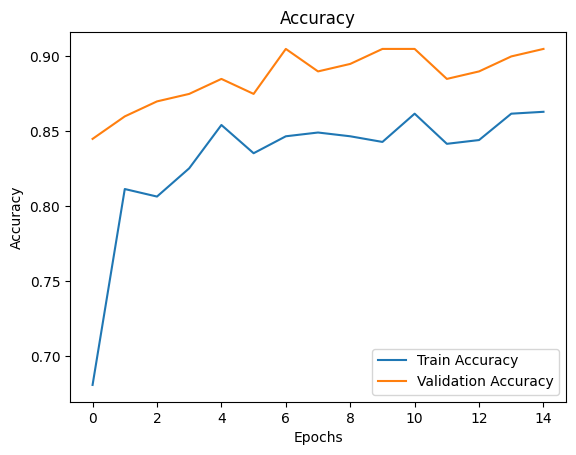

7/7 [==============================] - 0s 2ms/step


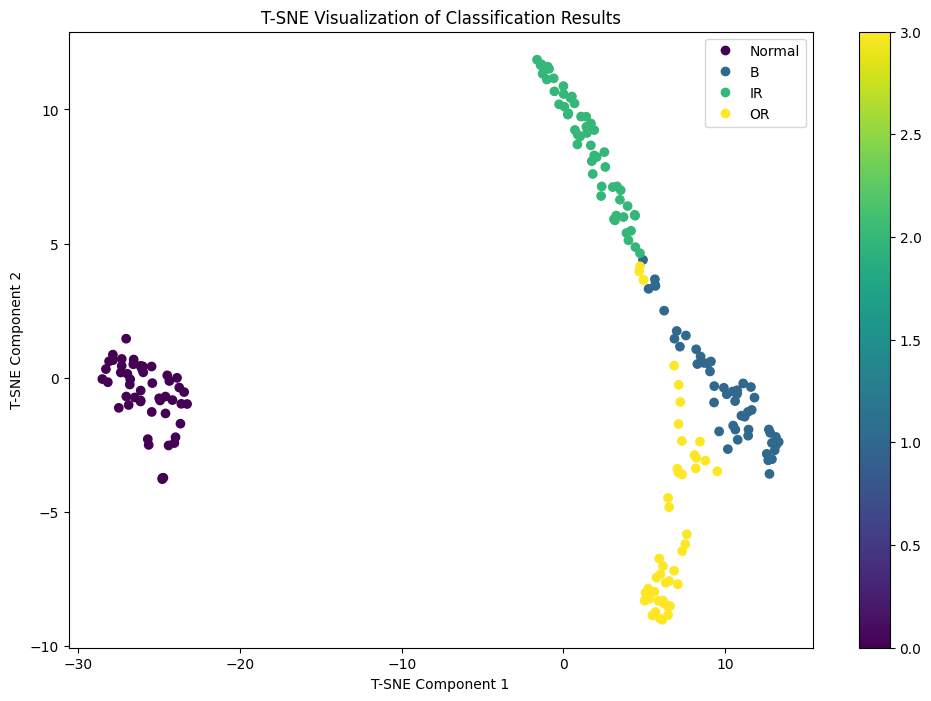

Accuracy on test set: 0.905
F1 score on test set: 0.90465018516665
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        50
           B       0.84      0.84      0.84        50
          IR       0.89      0.94      0.91        50
          OR       0.89      0.84      0.87        50

    accuracy                           0.91       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.91      0.91      0.90       200



In [25]:
################################################# GCN STFT LSTM  ################################################
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import scipy.signal
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
import scipy.io

# 데이터 파일 로드 및 정규화
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# .mat 파일 로드 및 데이터 추출
def load_and_extract_data(filepath, variables):
    mat = scipy.io.loadmat(filepath)
    data_list = [mat[var].flatten() for var in variables]
    min_length = min(len(data) for data in data_list)  # 가장 짧은 길이를 찾음
    data_list = [data[:min_length] for data in data_list]  # 모든 데이터를 가장 짧은 길이에 맞춤
    data = np.column_stack(data_list)
    return pd.DataFrame(data, columns=variables)

# 변수 이름에 맞게 데이터 로드
# NORMAL
normal_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/97_Normal_0.mat", ['X097_DE_time', 'X097_FE_time'])
normal_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/98_Normal_1.mat", ['X098_DE_time', 'X098_FE_time'])
normal_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/99_Normal_2.mat", ['X099_DE_time', 'X099_FE_time'])
normal_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/100_Normal_3.mat", ['X100_DE_time', 'X100_FE_time'])
# B DATA
B_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/118_0.mat", ['X118_DE_time', 'X118_FE_time'])
B_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/119_1.mat", ['X119_DE_time', 'X119_FE_time'])
B_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/120_2.mat", ['X120_DE_time', 'X120_FE_time'])
B_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/121_3.mat", ['X121_DE_time', 'X121_FE_time'])
B_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/185_0.mat", ['X185_DE_time', 'X185_FE_time'])
B_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/186_1.mat", ['X186_DE_time', 'X186_FE_time'])
B_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/187_2.mat", ['X187_DE_time', 'X187_FE_time'])
B_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/188_3.mat", ['X188_DE_time', 'X188_FE_time'])
B_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/222_0.mat", ['X222_DE_time', 'X222_FE_time'])
B_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/223_1.mat", ['X223_DE_time', 'X223_FE_time'])
B_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/224_2.mat", ['X224_DE_time', 'X224_FE_time'])
B_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/225_3.mat", ['X225_DE_time', 'X225_FE_time'])
# IR DATA
IR_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/105_0.mat", ['X105_DE_time', 'X105_FE_time'])
IR_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/106_1.mat", ['X106_DE_time', 'X106_FE_time'])
IR_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/107_2.mat", ['X107_DE_time', 'X107_FE_time'])
IR_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/108_3.mat", ['X108_DE_time', 'X108_FE_time'])
IR_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/169_0.mat", ['X169_DE_time', 'X169_FE_time'])
IR_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/170_1.mat", ['X170_DE_time', 'X170_FE_time'])
IR_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/171_2.mat", ['X171_DE_time', 'X171_FE_time'])
IR_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/172_3.mat", ['X172_DE_time', 'X172_FE_time'])
IR_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/209_0.mat", ['X209_DE_time', 'X209_FE_time'])
IR_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/210_1.mat", ['X210_DE_time', 'X210_FE_time'])
IR_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/211_2.mat", ['X211_DE_time', 'X211_FE_time'])
IR_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/212_3.mat", ['X212_DE_time', 'X212_FE_time'])
# OR DATA
OR_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/130@6_0.mat", ['X130_DE_time', 'X130_FE_time'])
OR_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/131@6_1.mat", ['X131_DE_time', 'X131_FE_time'])
OR_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/132@6_2.mat", ['X132_DE_time', 'X132_FE_time'])
OR_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/133@6_3.mat", ['X133_DE_time', 'X133_FE_time'])
OR_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/144_0.mat", ['X144_DE_time', 'X144_FE_time'])
OR_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/145_1.mat", ['X145_DE_time', 'X145_FE_time'])
OR_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/146_2.mat", ['X146_DE_time', 'X146_FE_time'])
OR_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/147_3.mat", ['X147_DE_time', 'X147_FE_time'])
OR_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/156_0.mat", ['X156_DE_time', 'X156_FE_time'])
OR_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/158_1.mat", ['X158_DE_time', 'X158_FE_time'])
OR_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/159_2.mat", ['X159_DE_time', 'X159_FE_time'])
OR_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/160_3.mat", ['X160_DE_time', 'X160_FE_time'])
OR_data13 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/197@6_0.mat", ['X197_DE_time', 'X197_FE_time'])
OR_data14 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/198@6_1.mat", ['X198_DE_time', 'X198_FE_time'])
OR_data15 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/199@6_2.mat", ['X199_DE_time', 'X199_FE_time'])
OR_data16 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/200@6_3.mat", ['X200_DE_time', 'X200_FE_time'])
OR_data17 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/234_0.mat", ['X234_DE_time', 'X234_FE_time'])
OR_data18 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/235_1.mat", ['X235_DE_time', 'X235_FE_time'])
OR_data19 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/236_2.mat", ['X236_DE_time', 'X236_FE_time'])
OR_data20 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/237_3.mat", ['X237_DE_time', 'X237_FE_time'])
OR_data21 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/246_0.mat", ['X246_DE_time', 'X246_FE_time'])
OR_data22 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/247_1.mat", ['X247_DE_time', 'X247_FE_time'])
OR_data23 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/248_2.mat", ['X248_DE_time', 'X248_FE_time'])
OR_data24 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/249_3.mat", ['X249_DE_time', 'X249_FE_time'])
OR_data25 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/258_0.mat", ['X258_DE_time', 'X258_FE_time'])
OR_data26 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/259_1.mat", ['X259_DE_time', 'X259_FE_time'])
OR_data27 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/260_2.mat", ['X260_DE_time', 'X260_FE_time'])
OR_data28 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/261_3.mat", ['X261_DE_time', 'X261_FE_time'])

# 데이터 프레임을 결합하기 전에 열 이름 맞추기
normal_data1.columns = ['motor1_x', 'motor1_y']
normal_data2.columns = ['motor1_x', 'motor1_y']
normal_data3.columns = ['motor1_x', 'motor1_y']
normal_data4.columns = ['motor1_x', 'motor1_y']
B_data1.columns = ['motor1_x', 'motor1_y']
B_data2.columns = ['motor1_x', 'motor1_y']
B_data3.columns = ['motor1_x', 'motor1_y']
B_data4.columns = ['motor1_x', 'motor1_y']
B_data5.columns = ['motor1_x', 'motor1_y']
B_data6.columns = ['motor1_x', 'motor1_y']
B_data7.columns = ['motor1_x', 'motor1_y']
B_data8.columns = ['motor1_x', 'motor1_y']
B_data9.columns = ['motor1_x', 'motor1_y']
B_data10.columns = ['motor1_x', 'motor1_y']
B_data11.columns = ['motor1_x', 'motor1_y']
B_data12.columns = ['motor1_x', 'motor1_y']
IR_data1.columns = ['motor1_x', 'motor1_y']
IR_data2.columns = ['motor1_x', 'motor1_y']
IR_data3.columns = ['motor1_x', 'motor1_y']
IR_data4.columns = ['motor1_x', 'motor1_y']
IR_data5.columns = ['motor1_x', 'motor1_y']
IR_data6.columns = ['motor1_x', 'motor1_y']
IR_data7.columns = ['motor1_x', 'motor1_y']
IR_data8.columns = ['motor1_x', 'motor1_y']
IR_data9.columns = ['motor1_x', 'motor1_y']
IR_data10.columns = ['motor1_x', 'motor1_y']
IR_data11.columns = ['motor1_x', 'motor1_y']
IR_data12.columns = ['motor1_x', 'motor1_y']
OR_data1.columns = ['motor1_x', 'motor1_y']
OR_data2.columns = ['motor1_x', 'motor1_y']
OR_data3.columns = ['motor1_x', 'motor1_y']
OR_data4.columns = ['motor1_x', 'motor1_y']
OR_data5.columns = ['motor1_x', 'motor1_y']
OR_data6.columns = ['motor1_x', 'motor1_y']
OR_data7.columns = ['motor1_x', 'motor1_y']
OR_data8.columns = ['motor1_x', 'motor1_y']
OR_data9.columns = ['motor1_x', 'motor1_y']
OR_data10.columns = ['motor1_x', 'motor1_y']
OR_data11.columns = ['motor1_x', 'motor1_y']
OR_data12.columns = ['motor1_x', 'motor1_y']
OR_data13.columns = ['motor1_x', 'motor1_y']
OR_data14.columns = ['motor1_x', 'motor1_y']
OR_data15.columns = ['motor1_x', 'motor1_y']
OR_data16.columns = ['motor1_x', 'motor1_y']
OR_data17.columns = ['motor1_x', 'motor1_y']
OR_data18.columns = ['motor1_x', 'motor1_y']
OR_data19.columns = ['motor1_x', 'motor1_y']
OR_data20.columns = ['motor1_x', 'motor1_y']
OR_data21.columns = ['motor1_x', 'motor1_y']
OR_data22.columns = ['motor1_x', 'motor1_y']
OR_data23.columns = ['motor1_x', 'motor1_y']
OR_data24.columns = ['motor1_x', 'motor1_y']
OR_data25.columns = ['motor1_x', 'motor1_y']
OR_data26.columns = ['motor1_x', 'motor1_y']
OR_data27.columns = ['motor1_x', 'motor1_y']
OR_data28.columns = ['motor1_x', 'motor1_y']


normal_data = pd.concat([normal_data1, normal_data2, normal_data3, normal_data4], axis=0)
B_data = pd.concat([B_data1, B_data2, B_data3, B_data4, B_data5, B_data6, B_data7, B_data8, B_data9, B_data10, B_data11, B_data12], axis=0)
IR_data = pd.concat([IR_data1, IR_data2, IR_data3, IR_data4, IR_data5, IR_data6, IR_data7, IR_data8, IR_data9, IR_data10, IR_data11, IR_data12], axis=0)
OR_data = pd.concat([OR_data1, OR_data2, OR_data3, OR_data4, OR_data5, OR_data6, OR_data7, OR_data8, OR_data9, OR_data10, OR_data11, OR_data12,OR_data13, OR_data14, OR_data15, OR_data16, OR_data17, OR_data18, OR_data19, OR_data20, OR_data21, OR_data22, OR_data23, OR_data24,OR_data25, OR_data26, OR_data27, OR_data28], axis=0)

# 샘플링
normal_data_sampled = normal_data.sample(n=8000, random_state=42)
B_data_sampled = B_data.sample(n=8000, random_state=42)
IR_data_sampled = IR_data.sample(n=8000, random_state=42)
OR_data_sampled = OR_data.sample(n=8000, random_state=42)

# 정규화
normal_data_scaled = normalize_data(normal_data_sampled)
B_data_scaled = normalize_data(B_data_sampled)
IR_data_scaled = normalize_data(IR_data_sampled)
OR_data_scaled = normalize_data(OR_data_sampled)

print(normal_data_sampled)
print(B_data_sampled)
print(IR_data_sampled)
print(OR_data_sampled)

def create_graph_data(data, k_neighbors=2):
    knn_graph = kneighbors_graph(data, k_neighbors, mode='connectivity', include_self=True)
    edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
    x = torch.tensor(data, dtype=torch.float)
    return Data(x=x, edge_index=edge_index)

normal_graph = create_graph_data(normal_data_scaled)
B_graph = create_graph_data(B_data_scaled)
IR_graph = create_graph_data(IR_data_scaled)
OR_graph = create_graph_data(OR_data_scaled)

# GCN 모델 정의
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# GCN 모델 학습 및 특징 추출
def train_gcn(graph_data, epochs=10):
    model = GCN(in_channels=graph_data.x.shape[1], hidden_channels=16, out_channels=graph_data.x.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    model.train()
    graph_data = graph_data.to(device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.x)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
    return model, out.detach().cpu().numpy()

print("Training GCN model for normal data...")
normal_model, normal_gcn_features = train_gcn(normal_graph)
print("Training GCN model for B damage data...")
B_model, B_gcn_features = train_gcn(B_graph)
print("Training GCN model for IR damage data...")
IR_model, IR_gcn_features = train_gcn(IR_graph)
print("Training GCN model for OR data...")
OR_model, OR_gcn_features = train_gcn(OR_graph)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

window_size = 64
step_size = 32

# 슬라이딩 윈도우 적용
normal_windows = sliding_window(normal_gcn_features, window_size, step_size)
B_windows = sliding_window(B_gcn_features, window_size, step_size)
IR_windows = sliding_window(IR_gcn_features, window_size, step_size)
OR_windows = sliding_window(OR_gcn_features, window_size, step_size)

# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array([np.abs(scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2]) for d in data])  # 절대값을 사용하여 실수 데이터로 변환

print("Computing STFT...")
normal_stft = compute_stft(normal_windows)
B_stft = compute_stft(B_windows)
IR_stft = compute_stft(IR_windows)
OR_stft = compute_stft(OR_windows)

# 데이터 합치기
def concatenate_data(*stft_data):
    min_time_steps = min(stft.shape[2] for stft in stft_data)
    return np.concatenate([stft[:, :, :min_time_steps] for stft in stft_data], axis=0)

X_normal = concatenate_data(normal_stft)
X_B = concatenate_data(B_stft)
X_IR = concatenate_data(IR_stft)
X_OR = concatenate_data(OR_stft)

# 레이블 생성
y_normal = np.zeros(X_normal.shape[0])
y_B = np.ones(X_B.shape[0])
y_IR = np.full((X_IR.shape[0],), 2)
y_OR = np.full((X_OR.shape[0],), 3)

# 데이터셋 합치기
X = np.concatenate((X_normal, X_B, X_IR, X_OR), axis=0)
y = np.concatenate((y_normal, y_B, y_IR, y_OR), axis=0)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 형태 확인
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (샘플 수, 시간, 특징 수)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print("Train data shape after reshape:", X_train.shape)
print("Test data shape after reshape:", X_test.shape)

# LSTM 분류 모델 정의
def create_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (시간, 특징 수)
model = create_lstm(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 훈련
print("Training LSTM model...")
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 서머리
model.summary()

# LSTM 모델에서 인코딩된 특징 추출
encoder = Model(inputs=model.input, outputs=model.layers[2].output)

X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# 인코딩된 데이터의 형태를 확인하고 평탄화
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# 다중 클래스 분류 모델 정의
classifier = Sequential()
classifier.add(Dense(64, input_shape=(X_train_encoded_flat.shape[1],)))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.2))
classifier.add(Dense(y_train.shape[1], activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 다중 클래스 분류 모델 훈련
print("Training classifier model...")
history = classifier.fit(X_train_encoded_flat, y_train, epochs=1000, batch_size=4, validation_data=(X_test_encoded_flat, y_test), callbacks=[early_stopping])

# 분류 모델 서머리
classifier.summary()

# 훈련 및 검증 데이터에 대한 손실 및 정확도 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = classifier.predict(X_test_encoded_flat)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
X_test_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_test_encoded_flat)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'B', 'IR', 'OR'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print("F1 score on test set:", f1_score(y_test_true_classes, y_test_pred_classes, average='weighted'))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'B', 'IR', 'OR']))

In [26]:
import torch
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


        motor1_x  motor1_y
402286 -0.056952 -0.040885
211646  0.043183  0.016231
218166 -0.030875  0.157378
478771 -0.052571  0.019107
70442  -0.028789  0.099645
...          ...       ...
301660  0.043809 -0.074580
308401  0.062167  0.019313
56336  -0.083446 -0.084647
309338 -0.105768  0.121424
379524 -0.104934  0.135189

[8000 rows x 2 columns]
        motor1_x  motor1_y
67877  -0.040284  0.126149
20571  -0.130111 -0.026093
66886  -0.004873 -0.004109
68240   0.231632 -0.077251
3046    0.095349 -0.000616
...          ...       ...
61828  -0.063350  0.000000
103345 -0.059126  0.123889
19814   0.016893 -0.069649
26198   0.120364 -0.031024
93524   0.032974 -0.074169

[8000 rows x 2 columns]
        motor1_x  motor1_y
60270  -0.128324  0.027736
50394   0.140182 -0.011505
117999 -0.048731  0.077662
80356  -0.024853  0.054445
66652  -0.001137  0.126560
...          ...       ...
57675  -0.159349  0.225795
42161   0.121664  0.108069
105751  0.049380  0.174842
91469   0.013401  0.187375
18308

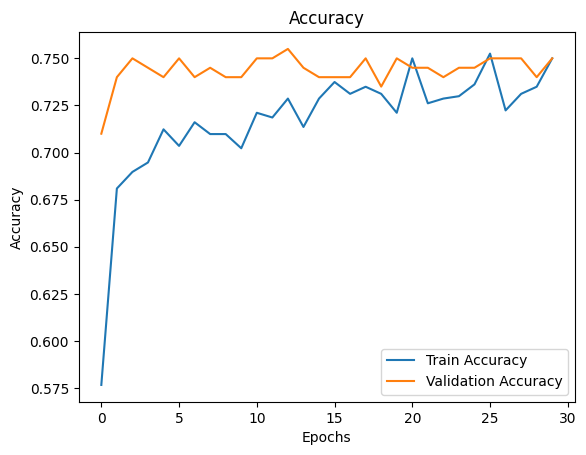

7/7 [==============================] - 0s 2ms/step


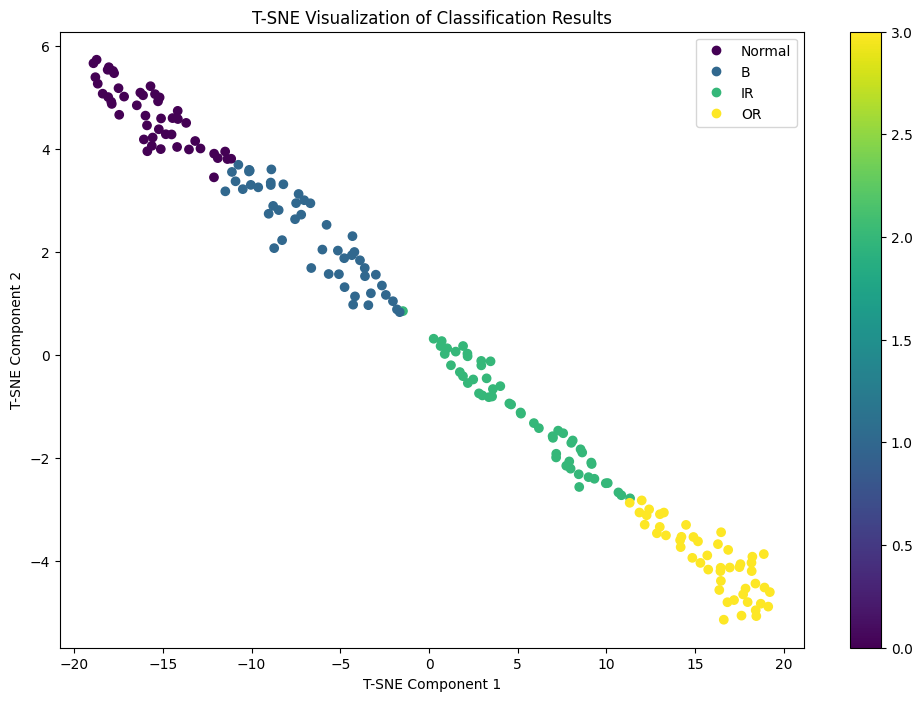

Accuracy on test set: 0.75
F1 score on test set: 0.7486023712827837
              precision    recall  f1-score   support

      Normal       0.70      0.66      0.68        50
           B       0.61      0.60      0.61        50
          IR       0.78      0.86      0.82        50
          OR       0.90      0.88      0.89        50

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



In [28]:
#################################################### STFT LSTM  ##################################################
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.signal
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.manifold import TSNE
import scipy.io

# 데이터 파일 로드 및 정규화
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# .mat 파일 로드 및 데이터 추출
def load_and_extract_data(filepath, variables):
    mat = scipy.io.loadmat(filepath)
    data_list = [mat[var].flatten() for var in variables]
    min_length = min(len(data) for data in data_list)  # 가장 짧은 길이를 찾음
    data_list = [data[:min_length] for data in data_list]  # 모든 데이터를 가장 짧은 길이에 맞춤
    data = np.column_stack(data_list)
    return pd.DataFrame(data, columns=variables)

# 변수 이름에 맞게 데이터 로드
# NORMAL
normal_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/97_Normal_0.mat", ['X097_DE_time', 'X097_FE_time'])
normal_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/98_Normal_1.mat", ['X098_DE_time', 'X098_FE_time'])
normal_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/99_Normal_2.mat", ['X099_DE_time', 'X099_FE_time'])
normal_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/100_Normal_3.mat", ['X100_DE_time', 'X100_FE_time'])
# B DATA
B_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/118_0.mat", ['X118_DE_time', 'X118_FE_time'])
B_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/119_1.mat", ['X119_DE_time', 'X119_FE_time'])
B_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/120_2.mat", ['X120_DE_time', 'X120_FE_time'])
B_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/121_3.mat", ['X121_DE_time', 'X121_FE_time'])
B_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/185_0.mat", ['X185_DE_time', 'X185_FE_time'])
B_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/186_1.mat", ['X186_DE_time', 'X186_FE_time'])
B_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/187_2.mat", ['X187_DE_time', 'X187_FE_time'])
B_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/188_3.mat", ['X188_DE_time', 'X188_FE_time'])
B_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/222_0.mat", ['X222_DE_time', 'X222_FE_time'])
B_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/223_1.mat", ['X223_DE_time', 'X223_FE_time'])
B_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/224_2.mat", ['X224_DE_time', 'X224_FE_time'])
B_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/225_3.mat", ['X225_DE_time', 'X225_FE_time'])
# IR DATA
IR_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/105_0.mat", ['X105_DE_time', 'X105_FE_time'])
IR_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/106_1.mat", ['X106_DE_time', 'X106_FE_time'])
IR_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/107_2.mat", ['X107_DE_time', 'X107_FE_time'])
IR_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/108_3.mat", ['X108_DE_time', 'X108_FE_time'])
IR_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/169_0.mat", ['X169_DE_time', 'X169_FE_time'])
IR_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/170_1.mat", ['X170_DE_time', 'X170_FE_time'])
IR_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/171_2.mat", ['X171_DE_time', 'X171_FE_time'])
IR_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/172_3.mat", ['X172_DE_time', 'X172_FE_time'])
IR_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/209_0.mat", ['X209_DE_time', 'X209_FE_time'])
IR_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/210_1.mat", ['X210_DE_time', 'X210_FE_time'])
IR_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/211_2.mat", ['X211_DE_time', 'X211_FE_time'])
IR_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/212_3.mat", ['X212_DE_time', 'X212_FE_time'])
# OR DATA
OR_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/130@6_0.mat", ['X130_DE_time', 'X130_FE_time'])
OR_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/131@6_1.mat", ['X131_DE_time', 'X131_FE_time'])
OR_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/132@6_2.mat", ['X132_DE_time', 'X132_FE_time'])
OR_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/133@6_3.mat", ['X133_DE_time', 'X133_FE_time'])
OR_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/144_0.mat", ['X144_DE_time', 'X144_FE_time'])
OR_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/145_1.mat", ['X145_DE_time', 'X145_FE_time'])
OR_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/146_2.mat", ['X146_DE_time', 'X146_FE_time'])
OR_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/147_3.mat", ['X147_DE_time', 'X147_FE_time'])
OR_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/156_0.mat", ['X156_DE_time', 'X156_FE_time'])
OR_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/158_1.mat", ['X158_DE_time', 'X158_FE_time'])
OR_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/159_2.mat", ['X159_DE_time', 'X159_FE_time'])
OR_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/160_3.mat", ['X160_DE_time', 'X160_FE_time'])
OR_data13 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/197@6_0.mat", ['X197_DE_time', 'X197_FE_time'])
OR_data14 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/198@6_1.mat", ['X198_DE_time', 'X198_FE_time'])
OR_data15 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/199@6_2.mat", ['X199_DE_time', 'X199_FE_time'])
OR_data16 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/200@6_3.mat", ['X200_DE_time', 'X200_FE_time'])
OR_data17 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/234_0.mat", ['X234_DE_time', 'X234_FE_time'])
OR_data18 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/235_1.mat", ['X235_DE_time', 'X235_FE_time'])
OR_data19 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/236_2.mat", ['X236_DE_time', 'X236_FE_time'])
OR_data20 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/237_3.mat", ['X237_DE_time', 'X237_FE_time'])
OR_data21 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/246_0.mat", ['X246_DE_time', 'X246_FE_time'])
OR_data22 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/247_1.mat", ['X247_DE_time', 'X247_FE_time'])
OR_data23 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/248_2.mat", ['X248_DE_time', 'X248_FE_time'])
OR_data24 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/249_3.mat", ['X249_DE_time', 'X249_FE_time'])
OR_data25 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/258_0.mat", ['X258_DE_time', 'X258_FE_time'])
OR_data26 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/259_1.mat", ['X259_DE_time', 'X259_FE_time'])
OR_data27 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/260_2.mat", ['X260_DE_time', 'X260_FE_time'])
OR_data28 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/261_3.mat", ['X261_DE_time', 'X261_FE_time'])

# 데이터 프레임을 결합하기 전에 열 이름 맞추기
normal_data1.columns = ['motor1_x', 'motor1_y']
normal_data2.columns = ['motor1_x', 'motor1_y']
normal_data3.columns = ['motor1_x', 'motor1_y']
normal_data4.columns = ['motor1_x', 'motor1_y']
B_data1.columns = ['motor1_x', 'motor1_y']
B_data2.columns = ['motor1_x', 'motor1_y']
B_data3.columns = ['motor1_x', 'motor1_y']
B_data4.columns = ['motor1_x', 'motor1_y']
B_data5.columns = ['motor1_x', 'motor1_y']
B_data6.columns = ['motor1_x', 'motor1_y']
B_data7.columns = ['motor1_x', 'motor1_y']
B_data8.columns = ['motor1_x', 'motor1_y']
B_data9.columns = ['motor1_x', 'motor1_y']
B_data10.columns = ['motor1_x', 'motor1_y']
B_data11.columns = ['motor1_x', 'motor1_y']
B_data12.columns = ['motor1_x', 'motor1_y']
IR_data1.columns = ['motor1_x', 'motor1_y']
IR_data2.columns = ['motor1_x', 'motor1_y']
IR_data3.columns = ['motor1_x', 'motor1_y']
IR_data4.columns = ['motor1_x', 'motor1_y']
IR_data5.columns = ['motor1_x', 'motor1_y']
IR_data6.columns = ['motor1_x', 'motor1_y']
IR_data7.columns = ['motor1_x', 'motor1_y']
IR_data8.columns = ['motor1_x', 'motor1_y']
IR_data9.columns = ['motor1_x', 'motor1_y']
IR_data10.columns = ['motor1_x', 'motor1_y']
IR_data11.columns = ['motor1_x', 'motor1_y']
IR_data12.columns = ['motor1_x', 'motor1_y']
OR_data1.columns = ['motor1_x', 'motor1_y']
OR_data2.columns = ['motor1_x', 'motor1_y']
OR_data3.columns = ['motor1_x', 'motor1_y']
OR_data4.columns = ['motor1_x', 'motor1_y']
OR_data5.columns = ['motor1_x', 'motor1_y']
OR_data6.columns = ['motor1_x', 'motor1_y']
OR_data7.columns = ['motor1_x', 'motor1_y']
OR_data8.columns = ['motor1_x', 'motor1_y']
OR_data9.columns = ['motor1_x', 'motor1_y']
OR_data10.columns = ['motor1_x', 'motor1_y']
OR_data11.columns = ['motor1_x', 'motor1_y']
OR_data12.columns = ['motor1_x', 'motor1_y']
OR_data13.columns = ['motor1_x', 'motor1_y']
OR_data14.columns = ['motor1_x', 'motor1_y']
OR_data15.columns = ['motor1_x', 'motor1_y']
OR_data16.columns = ['motor1_x', 'motor1_y']
OR_data17.columns = ['motor1_x', 'motor1_y']
OR_data18.columns = ['motor1_x', 'motor1_y']
OR_data19.columns = ['motor1_x', 'motor1_y']
OR_data20.columns = ['motor1_x', 'motor1_y']
OR_data21.columns = ['motor1_x', 'motor1_y']
OR_data22.columns = ['motor1_x', 'motor1_y']
OR_data23.columns = ['motor1_x', 'motor1_y']
OR_data24.columns = ['motor1_x', 'motor1_y']
OR_data25.columns = ['motor1_x', 'motor1_y']
OR_data26.columns = ['motor1_x', 'motor1_y']
OR_data27.columns = ['motor1_x', 'motor1_y']
OR_data28.columns = ['motor1_x', 'motor1_y']


normal_data = pd.concat([normal_data1, normal_data2, normal_data3, normal_data4], axis=0)
B_data = pd.concat([B_data1, B_data2, B_data3, B_data4, B_data5, B_data6, B_data7, B_data8, B_data9, B_data10, B_data11, B_data12], axis=0)
IR_data = pd.concat([IR_data1, IR_data2, IR_data3, IR_data4, IR_data5, IR_data6, IR_data7, IR_data8, IR_data9, IR_data10, IR_data11, IR_data12], axis=0)
OR_data = pd.concat([OR_data1, OR_data2, OR_data3, OR_data4, OR_data5, OR_data6, OR_data7, OR_data8, OR_data9, OR_data10, OR_data11, OR_data12,OR_data13, OR_data14, OR_data15, OR_data16, OR_data17, OR_data18, OR_data19, OR_data20, OR_data21, OR_data22, OR_data23, OR_data24,OR_data25, OR_data26, OR_data27, OR_data28], axis=0)

# 샘플링
normal_data_sampled = normal_data.sample(n=8000, random_state=42)
B_data_sampled = B_data.sample(n=8000, random_state=42)
IR_data_sampled = IR_data.sample(n=8000, random_state=42)
OR_data_sampled = OR_data.sample(n=8000, random_state=42)

# 정규화
normal_data_scaled = normalize_data(normal_data_sampled)
B_data_scaled = normalize_data(B_data_sampled)
IR_data_scaled = normalize_data(IR_data_sampled)
OR_data_scaled = normalize_data(OR_data_sampled)

print(normal_data_sampled)
print(B_data_sampled)
print(IR_data_sampled)
print(OR_data_sampled)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

window_size = 64
step_size = 32

# 슬라이딩 윈도우 적용
normal_windows = sliding_window(normal_data_scaled, window_size, step_size)
B_windows = sliding_window(B_data_scaled, window_size, step_size)
IR_windows = sliding_window(IR_data_scaled, window_size, step_size)
OR_windows = sliding_window(OR_data_scaled, window_size, step_size)

# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array([np.abs(scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2]) for d in data])  # 절대값을 사용하여 실수 데이터로 변환

print("Computing STFT...")
normal_stft = compute_stft(normal_windows)
B_stft = compute_stft(B_windows)
IR_stft = compute_stft(IR_windows)
OR_stft = compute_stft(OR_windows)

# 데이터 합치기
def concatenate_data(*stft_data):
    min_time_steps = min(stft.shape[2] for stft in stft_data)
    return np.concatenate([stft[:, :, :min_time_steps] for stft in stft_data], axis=0)

X_normal = concatenate_data(normal_stft)
X_B = concatenate_data(B_stft)
X_IR = concatenate_data(IR_stft)
X_OR = concatenate_data(OR_stft)

# 레이블 생성
y_normal = np.zeros(X_normal.shape[0])
y_B = np.ones(X_B.shape[0])
y_IR = np.full((X_IR.shape[0],), 2)
y_OR = np.full((X_OR.shape[0],), 3)

# 데이터셋 합치기
X = np.concatenate((X_normal, X_B, X_IR, X_OR), axis=0)
y = np.concatenate((y_normal, y_B, y_IR, y_OR), axis=0)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 형태 확인
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (샘플 수, 시간, 특징 수)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
print("Train data shape after reshape:", X_train.shape)
print("Test data shape after reshape:", X_test.shape)

# LSTM 분류 모델 정의
def create_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (시간, 특징 수)
model = create_lstm(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 훈련
print("Training LSTM model...")
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 서머리
model.summary()

# LSTM 모델에서 인코딩된 특징 추출
encoder = Model(inputs=model.input, outputs=model.layers[2].output)

X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# 인코딩된 데이터의 형태를 확인하고 평탄화
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# 다중 클래스 분류 모델 정의
classifier = Sequential()
classifier.add(Dense(64, input_shape=(X_train_encoded_flat.shape[1],)))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.2))
classifier.add(Dense(y_train.shape[1], activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 다중 클래스 분류 모델 훈련
print("Training classifier model...")
history = classifier.fit(X_train_encoded_flat, y_train, epochs=1000, batch_size=4, validation_data=(X_test_encoded_flat, y_test), callbacks=[early_stopping])

# 분류 모델 서머리
classifier.summary()

# 훈련 및 검증 데이터에 대한 손실 및 정확도 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = classifier.predict(X_test_encoded_flat)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
X_test_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_test_encoded_flat)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'B', 'IR', 'OR'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print("F1 score on test set:", f1_score(y_test_true_classes, y_test_pred_classes, average='weighted'))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'B', 'IR', 'OR']))



In [29]:
import torch
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


        motor1_x  motor1_y
402286 -0.056952 -0.040885
211646  0.043183  0.016231
218166 -0.030875  0.157378
478771 -0.052571  0.019107
70442  -0.028789  0.099645
...          ...       ...
301660  0.043809 -0.074580
308401  0.062167  0.019313
56336  -0.083446 -0.084647
309338 -0.105768  0.121424
379524 -0.104934  0.135189

[8000 rows x 2 columns]
        motor1_x  motor1_y
67877  -0.040284  0.126149
20571  -0.130111 -0.026093
66886  -0.004873 -0.004109
68240   0.231632 -0.077251
3046    0.095349 -0.000616
...          ...       ...
61828  -0.063350  0.000000
103345 -0.059126  0.123889
19814   0.016893 -0.069649
26198   0.120364 -0.031024
93524   0.032974 -0.074169

[8000 rows x 2 columns]
        motor1_x  motor1_y
60270  -0.128324  0.027736
50394   0.140182 -0.011505
117999 -0.048731  0.077662
80356  -0.024853  0.054445
66652  -0.001137  0.126560
...          ...       ...
57675  -0.159349  0.225795
42161   0.121664  0.108069
105751  0.049380  0.174842
91469   0.013401  0.187375
18308

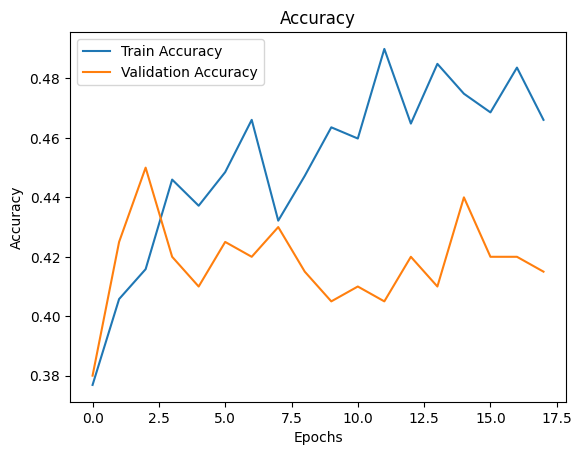

7/7 [==============================] - 0s 2ms/step


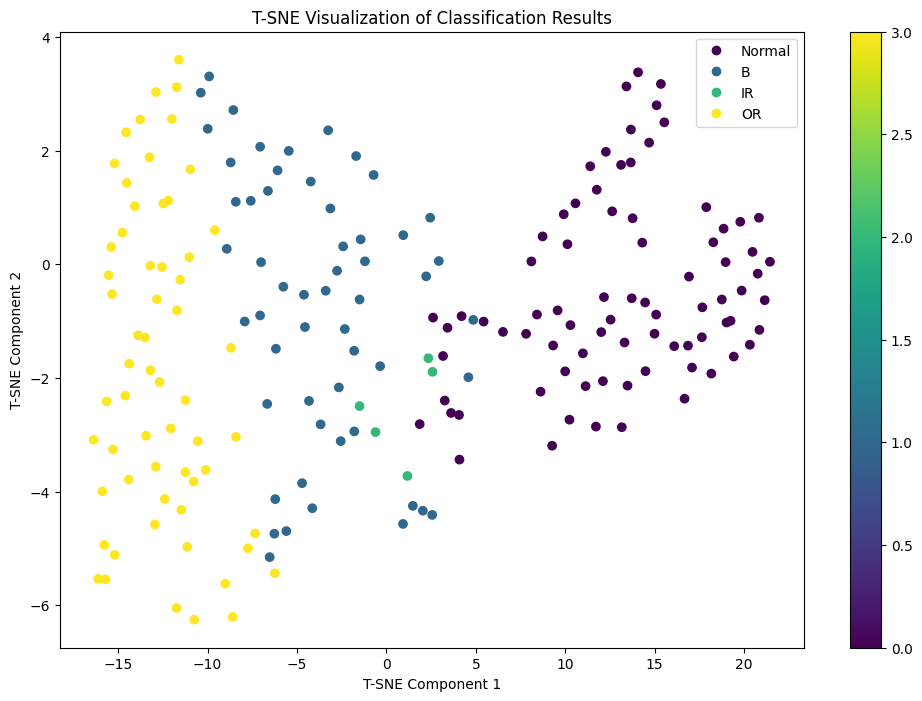

Accuracy on test set: 0.415
F1 score on test set: 0.3577922077922078
              precision    recall  f1-score   support

      Normal       0.49      0.78      0.60        50
           B       0.27      0.30      0.29        50
          IR       0.20      0.02      0.04        50
          OR       0.47      0.56      0.51        50

    accuracy                           0.41       200
   macro avg       0.36      0.42      0.36       200
weighted avg       0.36      0.41      0.36       200



In [30]:
####################################################  LSTM  #################################################
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.manifold import TSNE
import scipy.io

# 데이터 파일 로드 및 정규화
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# .mat 파일 로드 및 데이터 추출
def load_and_extract_data(filepath, variables):
    mat = scipy.io.loadmat(filepath)
    data_list = [mat[var].flatten() for var in variables]
    min_length = min(len(data) for data in data_list)  # 가장 짧은 길이를 찾음
    data_list = [data[:min_length] for data in data_list]  # 모든 데이터를 가장 짧은 길이에 맞춤
    data = np.column_stack(data_list)
    return pd.DataFrame(data, columns=variables)

# 변수 이름에 맞게 데이터 로드
# NORMAL
normal_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/97_Normal_0.mat", ['X097_DE_time', 'X097_FE_time'])
normal_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/98_Normal_1.mat", ['X098_DE_time', 'X098_FE_time'])
normal_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/99_Normal_2.mat", ['X099_DE_time', 'X099_FE_time'])
normal_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/Normal/100_Normal_3.mat", ['X100_DE_time', 'X100_FE_time'])
# B DATA
B_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/118_0.mat", ['X118_DE_time', 'X118_FE_time'])
B_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/119_1.mat", ['X119_DE_time', 'X119_FE_time'])
B_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/120_2.mat", ['X120_DE_time', 'X120_FE_time'])
B_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007/121_3.mat", ['X121_DE_time', 'X121_FE_time'])
B_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/185_0.mat", ['X185_DE_time', 'X185_FE_time'])
B_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/186_1.mat", ['X186_DE_time', 'X186_FE_time'])
B_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/187_2.mat", ['X187_DE_time', 'X187_FE_time'])
B_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014/188_3.mat", ['X188_DE_time', 'X188_FE_time'])
B_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/222_0.mat", ['X222_DE_time', 'X222_FE_time'])
B_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/223_1.mat", ['X223_DE_time', 'X223_FE_time'])
B_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/224_2.mat", ['X224_DE_time', 'X224_FE_time'])
B_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021/225_3.mat", ['X225_DE_time', 'X225_FE_time'])
# IR DATA
IR_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/105_0.mat", ['X105_DE_time', 'X105_FE_time'])
IR_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/106_1.mat", ['X106_DE_time', 'X106_FE_time'])
IR_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/107_2.mat", ['X107_DE_time', 'X107_FE_time'])
IR_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007/108_3.mat", ['X108_DE_time', 'X108_FE_time'])
IR_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/169_0.mat", ['X169_DE_time', 'X169_FE_time'])
IR_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/170_1.mat", ['X170_DE_time', 'X170_FE_time'])
IR_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/171_2.mat", ['X171_DE_time', 'X171_FE_time'])
IR_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014/172_3.mat", ['X172_DE_time', 'X172_FE_time'])
IR_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/209_0.mat", ['X209_DE_time', 'X209_FE_time'])
IR_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/210_1.mat", ['X210_DE_time', 'X210_FE_time'])
IR_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/211_2.mat", ['X211_DE_time', 'X211_FE_time'])
IR_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021/212_3.mat", ['X212_DE_time', 'X212_FE_time'])
# OR DATA
OR_data1 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/130@6_0.mat", ['X130_DE_time', 'X130_FE_time'])
OR_data2 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/131@6_1.mat", ['X131_DE_time', 'X131_FE_time'])
OR_data3 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/132@6_2.mat", ['X132_DE_time', 'X132_FE_time'])
OR_data4 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6/133@6_3.mat", ['X133_DE_time', 'X133_FE_time'])
OR_data5 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/144_0.mat", ['X144_DE_time', 'X144_FE_time'])
OR_data6 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/145_1.mat", ['X145_DE_time', 'X145_FE_time'])
OR_data7 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/146_2.mat", ['X146_DE_time', 'X146_FE_time'])
OR_data8 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3/147_3.mat", ['X147_DE_time', 'X147_FE_time'])
OR_data9 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/156_0.mat", ['X156_DE_time', 'X156_FE_time'])
OR_data10 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/158_1.mat", ['X158_DE_time', 'X158_FE_time'])
OR_data11 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/159_2.mat", ['X159_DE_time', 'X159_FE_time'])
OR_data12 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12/160_3.mat", ['X160_DE_time', 'X160_FE_time'])
OR_data13 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/197@6_0.mat", ['X197_DE_time', 'X197_FE_time'])
OR_data14 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/198@6_1.mat", ['X198_DE_time', 'X198_FE_time'])
OR_data15 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/199@6_2.mat", ['X199_DE_time', 'X199_FE_time'])
OR_data16 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014/200@6_3.mat", ['X200_DE_time', 'X200_FE_time'])
OR_data17 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/234_0.mat", ['X234_DE_time', 'X234_FE_time'])
OR_data18 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/235_1.mat", ['X235_DE_time', 'X235_FE_time'])
OR_data19 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/236_2.mat", ['X236_DE_time', 'X236_FE_time'])
OR_data20 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6/237_3.mat", ['X237_DE_time', 'X237_FE_time'])
OR_data21 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/246_0.mat", ['X246_DE_time', 'X246_FE_time'])
OR_data22 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/247_1.mat", ['X247_DE_time', 'X247_FE_time'])
OR_data23 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/248_2.mat", ['X248_DE_time', 'X248_FE_time'])
OR_data24 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3/249_3.mat", ['X249_DE_time', 'X249_FE_time'])
OR_data25 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/258_0.mat", ['X258_DE_time', 'X258_FE_time'])
OR_data26 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/259_1.mat", ['X259_DE_time', 'X259_FE_time'])
OR_data27 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/260_2.mat", ['X260_DE_time', 'X260_FE_time'])
OR_data28 = load_and_extract_data("./drive/MyDrive/Dataset/CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12/261_3.mat", ['X261_DE_time', 'X261_FE_time'])

# 데이터 프레임을 결합하기 전에 열 이름 맞추기
normal_data1.columns = ['motor1_x', 'motor1_y']
normal_data2.columns = ['motor1_x', 'motor1_y']
normal_data3.columns = ['motor1_x', 'motor1_y']
normal_data4.columns = ['motor1_x', 'motor1_y']
B_data1.columns = ['motor1_x', 'motor1_y']
B_data2.columns = ['motor1_x', 'motor1_y']
B_data3.columns = ['motor1_x', 'motor1_y']
B_data4.columns = ['motor1_x', 'motor1_y']
B_data5.columns = ['motor1_x', 'motor1_y']
B_data6.columns = ['motor1_x', 'motor1_y']
B_data7.columns = ['motor1_x', 'motor1_y']
B_data8.columns = ['motor1_x', 'motor1_y']
B_data9.columns = ['motor1_x', 'motor1_y']
B_data10.columns = ['motor1_x', 'motor1_y']
B_data11.columns = ['motor1_x', 'motor1_y']
B_data12.columns = ['motor1_x', 'motor1_y']
IR_data1.columns = ['motor1_x', 'motor1_y']
IR_data2.columns = ['motor1_x', 'motor1_y']
IR_data3.columns = ['motor1_x', 'motor1_y']
IR_data4.columns = ['motor1_x', 'motor1_y']
IR_data5.columns = ['motor1_x', 'motor1_y']
IR_data6.columns = ['motor1_x', 'motor1_y']
IR_data7.columns = ['motor1_x', 'motor1_y']
IR_data8.columns = ['motor1_x', 'motor1_y']
IR_data9.columns = ['motor1_x', 'motor1_y']
IR_data10.columns = ['motor1_x', 'motor1_y']
IR_data11.columns = ['motor1_x', 'motor1_y']
IR_data12.columns = ['motor1_x', 'motor1_y']
OR_data1.columns = ['motor1_x', 'motor1_y']
OR_data2.columns = ['motor1_x', 'motor1_y']
OR_data3.columns = ['motor1_x', 'motor1_y']
OR_data4.columns = ['motor1_x', 'motor1_y']
OR_data5.columns = ['motor1_x', 'motor1_y']
OR_data6.columns = ['motor1_x', 'motor1_y']
OR_data7.columns = ['motor1_x', 'motor1_y']
OR_data8.columns = ['motor1_x', 'motor1_y']
OR_data9.columns = ['motor1_x', 'motor1_y']
OR_data10.columns = ['motor1_x', 'motor1_y']
OR_data11.columns = ['motor1_x', 'motor1_y']
OR_data12.columns = ['motor1_x', 'motor1_y']
OR_data13.columns = ['motor1_x', 'motor1_y']
OR_data14.columns = ['motor1_x', 'motor1_y']
OR_data15.columns = ['motor1_x', 'motor1_y']
OR_data16.columns = ['motor1_x', 'motor1_y']
OR_data17.columns = ['motor1_x', 'motor1_y']
OR_data18.columns = ['motor1_x', 'motor1_y']
OR_data19.columns = ['motor1_x', 'motor1_y']
OR_data20.columns = ['motor1_x', 'motor1_y']
OR_data21.columns = ['motor1_x', 'motor1_y']
OR_data22.columns = ['motor1_x', 'motor1_y']
OR_data23.columns = ['motor1_x', 'motor1_y']
OR_data24.columns = ['motor1_x', 'motor1_y']
OR_data25.columns = ['motor1_x', 'motor1_y']
OR_data26.columns = ['motor1_x', 'motor1_y']
OR_data27.columns = ['motor1_x', 'motor1_y']
OR_data28.columns = ['motor1_x', 'motor1_y']


normal_data = pd.concat([normal_data1, normal_data2, normal_data3, normal_data4], axis=0)
B_data = pd.concat([B_data1, B_data2, B_data3, B_data4, B_data5, B_data6, B_data7, B_data8, B_data9, B_data10, B_data11, B_data12], axis=0)
IR_data = pd.concat([IR_data1, IR_data2, IR_data3, IR_data4, IR_data5, IR_data6, IR_data7, IR_data8, IR_data9, IR_data10, IR_data11, IR_data12], axis=0)
OR_data = pd.concat([OR_data1, OR_data2, OR_data3, OR_data4, OR_data5, OR_data6, OR_data7, OR_data8, OR_data9, OR_data10, OR_data11, OR_data12,OR_data13, OR_data14, OR_data15, OR_data16, OR_data17, OR_data18, OR_data19, OR_data20, OR_data21, OR_data22, OR_data23, OR_data24,OR_data25, OR_data26, OR_data27, OR_data28], axis=0)

# 샘플링
normal_data_sampled = normal_data.sample(n=8000, random_state=42)
B_data_sampled = B_data.sample(n=8000, random_state=42)
IR_data_sampled = IR_data.sample(n=8000, random_state=42)
OR_data_sampled = OR_data.sample(n=8000, random_state=42)

# 정규화
normal_data_scaled = normalize_data(normal_data_sampled)
B_data_scaled = normalize_data(B_data_sampled)
IR_data_scaled = normalize_data(IR_data_sampled)
OR_data_scaled = normalize_data(OR_data_sampled)

print(normal_data_sampled)
print(B_data_sampled)
print(IR_data_sampled)
print(OR_data_sampled)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end])
    return np.array(windows)

window_size = 64
step_size = 32

# 슬라이딩 윈도우 적용
normal_windows = sliding_window(normal_data_scaled, window_size, step_size)
B_windows = sliding_window(B_data_scaled, window_size, step_size)
IR_windows = sliding_window(IR_data_scaled, window_size, step_size)
OR_windows = sliding_window(OR_data_scaled, window_size, step_size)

# 데이터 합치기
X_normal = normal_windows
X_B = B_windows
X_IR = IR_windows
X_OR = OR_windows

# 레이블 생성
y_normal = np.zeros(X_normal.shape[0])
y_B = np.ones(X_B.shape[0])
y_IR = np.full((X_IR.shape[0],), 2)
y_OR = np.full((X_OR.shape[0],), 3)

# 데이터셋 합치기
X = np.concatenate((X_normal, X_B, X_IR, X_OR), axis=0)
y = np.concatenate((y_normal, y_B, y_IR, y_OR), axis=0)

# 레이블을 원-핫 인코딩으로 변환
y = to_categorical(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 형태 확인
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# LSTM 분류 모델 정의
def create_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (시간, 특징 수)
model = create_lstm(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# 모델 훈련
print("Training LSTM model...")
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 모델 서머리
model.summary()

# LSTM 모델에서 인코딩된 특징 추출
encoder = Model(inputs=model.input, outputs=model.layers[2].output)

X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# 인코딩된 데이터의 형태를 확인하고 평탄화
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_test_encoded_flat = X_test_encoded.reshape(X_test_encoded.shape[0], -1)

# 다중 클래스 분류 모델 정의
classifier = Sequential()
classifier.add(Dense(64, input_shape=(X_train_encoded_flat.shape[1],)))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.5))
classifier.add(Dense(32))
classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU 활성화 함수 사용
classifier.add(Dropout(0.2))
classifier.add(Dense(y_train.shape[1], activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 다중 클래스 분류 모델 훈련
print("Training classifier model...")
history = classifier.fit(X_train_encoded_flat, y_train, epochs=1000, batch_size=4, validation_data=(X_test_encoded_flat, y_test), callbacks=[early_stopping])

# 분류 모델 서머리
classifier.summary()

# 훈련 및 검증 데이터에 대한 손실 및 정확도 확인
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 데이터에 대한 예측 및 평가
y_test_pred = classifier.predict(X_test_encoded_flat)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# 분류 결과의 T-SNE 시각화
X_test_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_test_encoded_flat)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test_pred_classes, cmap='viridis')
plt.colorbar()
plt.title("T-SNE Visualization of Classification Results")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'B', 'IR', 'OR'])
plt.show()

print("Accuracy on test set:", accuracy_score(y_test_true_classes, y_test_pred_classes))
print("F1 score on test set:", f1_score(y_test_true_classes, y_test_pred_classes, average='weighted'))
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=['Normal', 'B', 'IR', 'OR']))

